![banner](../static/banner.png)

---

# Part 4 - Creating neural networks to classify handwritten digits 🔢✍🏾

## Classifying handwritten digits 2️⃣

Consider the following sequence of handwritten digits.

![handwritten-digits](../static/digit_seq.png)

Many of us learn to how to read such numerals at a young age, and can effortlessly recognize those digits as 504192. But how could we go about getting a computer to recognise these digits?

We could try programming in some of our intuitions and heuristics for recognising digits, such as "a 2 has an arch at the top, connected to a horizontal stroke at the bottom". But some twos are written with a loop at the bottom, some are written a bit thicker, some have blotches, and some don't even really look like twos!

![twos](../static/twos.png)

While the human brain seems to easily identify all these symbols as twos, it turns out explicitly defining rules for identifying a two is incredibly difficult. But if we can't figure out exactly how to tell the computer to recognise a two, maybe we can try and help it learn itself? It turns out this works surprisingly well! Even the most basic neural network, which we'll create below, can do this fairly well. 

But before we dive into creating a neural network, we need a source of data.

## The MNIST database 🧮

The [MNIST database](https://en.wikipedia.org/wiki/MNIST_database) is a large (and now, after being used in many machine learning tutorials, famous) database containing thousands of handwritten digits, from 0 through 9, written by samples of American high-school students and employees from the American Census Bureau. If we were dealing with data in the real world, it would be all kinds of messy and require susbtantial preprocesing. Luckily, the [creators of this database](http://yann.lecun.com/exdb/mnist/) have done all the work for us in making the data nice and clean.

![MNIST](../static/rand_digits.png)

Each image of a handwritten digit has been reduced to a square 28 by 28 pixel image, for a total of **784 pixels**. Each digit is centered in the image. Because these images are greyscale, we can describe the appearance of each pixel in one number, representing the "brightness". We'll say that a completely white pixel has the value 0, and a completely black pixel the value of 1. Using this encoding, we can represent each handwritten digit image by 28 by 28 matrix. An example of how the image of the handwritten 1 on the left would be encoded as a matrix is shown below.

![MNIST](../static/mnist.png)

This matrix can then be "unfolded" into a single list of 784 values between 0 and 1. This is how the data is formatted and stored in the `.csv` file we'll used to train and test our neural network. Let's load in the data now and take a look.

<font color='#F89536'> **Your turn:** </font> Run the cell below to load the data. What do the rows and columns represent?

In [1]:
# Read in the csv
library(data.table)
mnist = data.table::fread("../data/MNIST_normalised.csv")
                    
# Convert the data into a matrix to make it easier to do math
mnist = as.matrix(mnist)

# Name rows and columns for clarity
rownames(mnist) = c("label", paste0("pixel", 1:(nrow(mnist) - 1)))
colnames(mnist) = 1:ncol(mnist)

# Print the number of rows and columns in the data set
cat(paste0("Rows: ", nrow(mnist), "\nColumns: ", ncol(mnist)))

# Display a subset of the data set
mnist[c(1:4, 124:127, 783:785), 1:20]

Rows: 785
Columns: 42000

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
label,3,0.00,3.00,5,2.00,0,6.00,3,2,7,7,4,6,5,1,7,2.00,4,2,5
pixel1,0,0.00,0.00,0,0.00,0,0.00,0,0,0,0,0,0,0,0,0,0.00,0,0,0
pixel2,0,0.00,0.00,0,0.00,0,0.00,0,0,0,0,0,0,0,0,0,0.00,0,0,0
pixel3,0,0.00,0.00,0,0.00,0,0.00,0,0,0,0,0,0,0,0,0,0.00,0,0,0
pixel123,0,0.83,0.99,0,0.00,0,0.00,0,0,0,0,0,0,0,0,0,0.80,0,0,0
pixel124,0,1.00,0.99,0,0.48,0,0.00,0,0,0,0,0,0,0,0,0,0.99,0,0,0
pixel125,0,0.63,0.99,0,0.99,0,0.00,0,0,0,0,0,0,0,0,0,0.99,0,0,0
pixel126,0,0.36,1.00,0,0.99,0,0.49,0,0,0,0,0,0,0,0,0,0.98,0,0,0
pixel782,0,0.00,0.00,0,0.00,0,0.00,0,0,0,0,0,0,0,0,0,0.00,0,0,0
pixel783,0,0.00,0.00,0,0.00,0,0.00,0,0,0,0,0,0,0,0,0,0.00,0,0,0


Each of the 42,000 columns in the data corresponds to a distinct handwritten digit example. The first row tells us what digit is represented in that column, and the remaining 784 rows encode the brightness of the 784 pixels in each image, on a scale of 0 to 1. (Note that, unlike most datasets, each observation is given a column, not a row. This is to help make coding the maths easier.)

We're almost done getting our data ready, the last step is to split our data. We do this in two ways:
1. Into training and test sets. We'll take the first 4000 columns as our testing data-set, and leave the rest to help train our network. 
2. Into the pixel values (`X_train` and `X_test`) and the labels (`Y_train` and `Y_test`).

<font color='#F89536'> **Your turn:** </font> Why do we split the data the second way? What would happen if we didn't?

In [2]:
n = nrow(mnist)
m = ncol(mnist)

test = mnist[, 1:4000]
Y_test = test[1, ]
X_test = test[2:n, ]

train = mnist[, 4001:m]
Y_train = train[1, ]
X_train = train[2:n, ]

## Planning our neural network 🤔

So we're going to try and create a neural network to help us classify these digits, but what type of neural network? There are many types of neural networks out there (come along to Part 3 of series to learn more on this), but for today, lets keep things relatively simple. We'll create a multilayer perceptron (MLP) with one hidden layer.

<font color='#F89536'> **Your turn:** </font> In the empty cell below, write down what key components and/or processes you think we might need to build in order to create our neural network. This can be a list of specific functions, or a general description of things it will need to be able to do. When you're ready, open the collapsed cell below to read how we'll go about it.

`Write your answer here`

Using our code, we'll need to be able to:
- Initialise the weights and biases of our network
- Apply an activation function
- Pass data forward through the network to make predictions (forward propagation)
- Comparing predictions against actual values, figure out how we should adjust the weights and biases (back propagation)
- Update the weights and biases
- Use forward propagation and backpropagation iteratively to train our model (gradient descent)
- Measure how good the predictions are
- Test the accuracy of the model

## Let's code it up 👩‍💻

While we already sorted out loading in our training and test data, there's a few more things we need to do before we can get started:
1. Load in the `ggplot2` library to help plot some graphs.
2. Set the random number generator seed, so that our results are reproducible.
3. Define a few **helper functions** to simplify some of the neural network code. 

We've defined a few helper functions to make a few boring things (like viewing progress while training our network) easier. **You don't need to understand these, and we recommend you don't spend much looking at them**. The names should help indicate what they do,  but feel free to take a look if you're curious!

<font color='#F89536'> **Your turn:** </font> Run the two cells below (watch out, one of them is collapsed to save space) to complete the steps above.

In [3]:
library(ggplot2)
set.seed(1)

In [4]:
one_hot = function(Y) {
  # Converts Y from a list of numbers (categorical variables) to a matrix.
  # In this matrix, each column corresponds to a digit. In each column, all
  # entries are zero except there is a single 1. The row that this 1 is in
  # encodes what number the digit encoded in that column is.
  # For example, a 1 in column 78, row 6 of the matrix would mean that the 78th 
  # digit in Y is a 5 (since row numbers start from 1, but our lowest digit is 0).
  one_hot_Y = matrix(0, length(Y), max(Y) + 1)
  for(i in 1:length(Y)) {
    one_hot_Y[i, Y[i] + 1] = 1
  }
  one_hot_Y = t(one_hot_Y)
  return(one_hot_Y)
}

print_training_progress = function(nn, Y, iteration) {
    # Prints to console some information as the network is being trained
    cat("-*-")
    flush.console()

    if (iteration %% 10 == 0) {
      cat("\n")
      predictions = get_predictions(nn)
      accuracy = get_accuracy(predictions, Y)
      cat(paste0("Iteration: ", iteration, ", Accuracy: ", round(accuracy, 2), "\n"))
      flush.console()
    }
}

plot_activation = function(activation_function, x = seq(-7,7,0.001)) {
    # Used to plot the activation function
    df = data.frame(x = x, y = activation_function(x))
    options(repr.plot.width = 12, repr.plot.height = 5)
    
    ggplot(df, aes(x, y)) +
      geom_line(lwd = 1.5) +
      theme_minimal() +
      theme(text = element_text(size = 20), element_line(size = 1)) +
      ylab(paste0("y = ", deparse(substitute(activation_function)), "(x)"))
}

display_digit = function(X, digit_index, label = TRUE) {
    # Plots a visual representation of a digit.
    digit = matrix(X[, digit_index], nrow = 28, ncol = 28)
    digit = digit[, nrow(digit):1]     # The image function is annoying, it flips matrices upside down, this fixes it.
    image(1:28, 1:28, digit, col = gray((255:0)/255.), axes = FALSE, xlab = "", ylab = "")
    box(col = "black") 
    if(label) {
        title(paste0("Digit label: ", as.character(Y_train[digit_index])), col.main = "black", line = 0.7, cex.main = 2)
    }
}

display_incorrect = function(incorrect, predictions, X_test, Y_test) {
    # Plots the first 24 incorrect predictions by the nn.
    options(repr.plot.width = 10, repr.plot.height = 10)
    par(
        mfcol = c(4, 6), 
        mar = c(0, 0, 8, 0)
    )
    for (id in incorrect[1:24]) {
        digit = matrix(X_test[, id], nrow = 28, ncol = 28)
        digit = digit[, nrow(digit):1]
        image(1:28, 1:28, digit, col = gray((255:0)/255), axes = FALSE)
        title(
            paste0("Actual: ", as.character(Y_test[id]), "\n Predicted: ", predictions[id]), 
            col.main = "black", 
            line = 0.7, 
            cex.main = 2
        )
    }
}

### A word of advice 💡
As we jump into the code below, don't stress if things don't click straight away (especially if you don't have much experience). Where you can, see if you can read through the code, line by line, to get a good idea of what exactly is going on.

### The activation function
Here we define the activation function we'll use in our network (and it's derivative). The function we'll use for our network is a classic, called the ***sigmoid function***, given by:
$$f(x) = \frac{1}{1 + e^{-x}}.$$

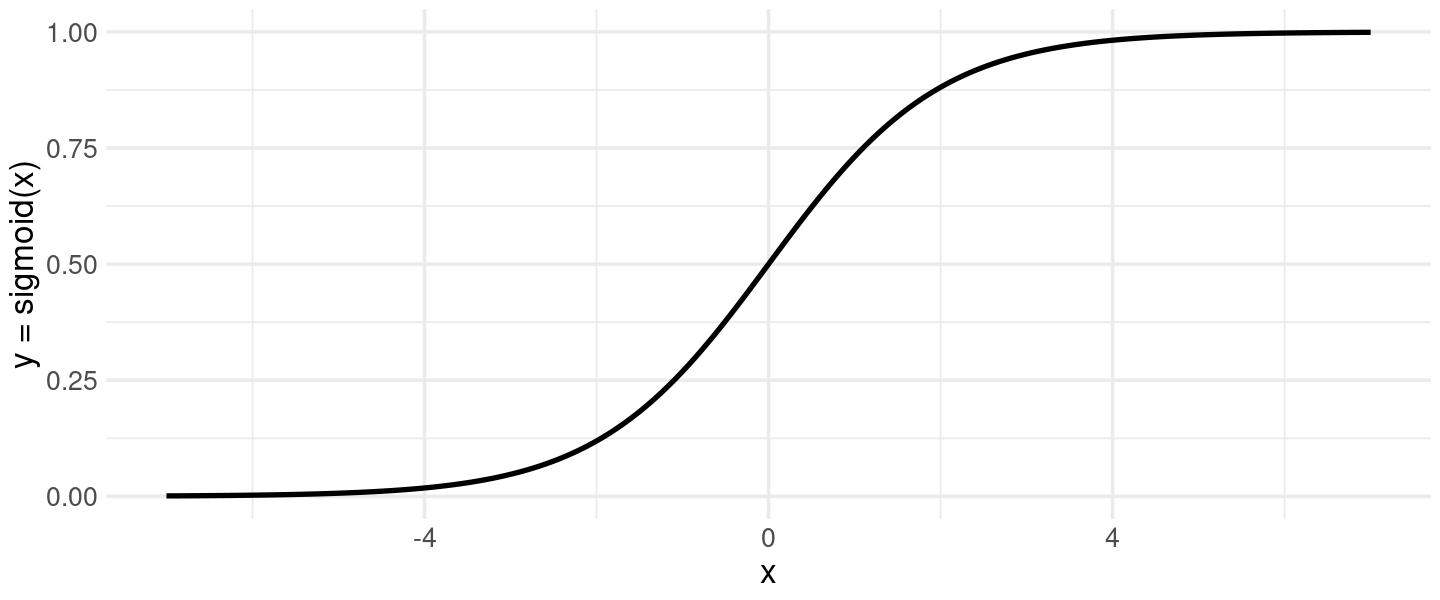

In [5]:
sigmoid = function(Z) {
  # The sigmoid function.
  return(1/(1 + exp(-Z)))
}

sigmoid_derivative = function(Z) {
  # The derivative of the sigmoid function.
  return(sigmoid(Z) * (1 - sigmoid(Z)))
}

plot_activation(sigmoid)

### Initialising the neural network
In order to train our network to recognise digits, we first have to create it! 

The function below initialises our neural network with random weights and biases (sampled from a standard normal), and returns them as a list. As described above, we focus on creating a simple network with one hidden layer.

Recall that if there are $n$ nodes in one layer and $m$ nodes in the next layer, then we'll have $n \times m$ weights in total. We neatly store these in a matrix, where each row contains all the weights linking to a given neuron in the next layer.

<font color='#F89536'> **Your turn:** </font> How many neurons should we have in our input layer? How about in our output layer? Replace the `???` in the function below.

In [6]:
initialise_net = function(num_hidden_nodes = 16) {
  # Initialises a neural network with one hidden layer.
  # Takes in an integer representing the number of nodes to be placed in the hidden layer.
  # Returns a list containing randomly initialised weights and biases.
    
  num_layers = 3 # One input layer, one hidden layer and one output layer for a total of three layers
  n_h = num_hidden_nodes # Change name for brevity
  
  n_input = 784 # Number of neurons in the input layer
  n_output = 10 # Number of neurons in the output layer

  nn = list(
    num_layers = num_layers,
    # Create a matrix to hold all the weights from the input layer to the hidden layer
    W1 = matrix(data = rnorm(n_input * num_hidden_nodes), nrow = n_h, ncol = n_input),
    b1 = rnorm(n_h),
    # Create a matrix to hold all the weights from the hidden layer to the output layer
    W2 = matrix(data = rnorm(n_h * n_output), nrow = n_output, ncol = n_h),
    b2 = rnorm(n_output)
  ) 
  return(nn)
}

Run the cell below to initialise a neural network and view its contents.

In [7]:
initialise_net()

-0.62645381,-0.01619026,0.38767161,-0.11234621,-0.743273209,-0.5686687,-1.27659221,1.43228224,-0.68166048,-1.11592011,⋯,0.46673527,1.246167839,0.33908238,-0.05577232,-0.4060760,-1.2461502,-0.8265499,0.91996960,-1.76687399,-1.84230698
0.18364332,0.94383621,-0.05380504,0.88110773,0.188792300,-0.1351786,-0.57326541,-0.65069635,-0.32427027,-0.75081900,⋯,0.55626076,1.836890780,0.48207506,0.42424287,-1.6836548,3.5492233,1.5774574,-1.44709018,0.24747775,-0.33415838
-0.83562861,0.82122120,-1.37705956,0.39810588,-1.804958629,1.1780870,-1.22461261,-0.20738074,0.06016044,2.08716655,⋯,1.55566523,-0.005664594,-1.92983836,-0.74870131,-0.7495989,-0.9491635,-0.2361763,0.42931336,-1.17414844,0.35216880
1.59528080,0.59390132,-0.41499456,-0.61202639,1.465554862,-1.5235668,-0.47340064,-0.39280793,-0.58889449,0.01739562,⋯,-1.25259638,-0.238459567,0.45519252,0.07302686,0.2599330,1.8191075,-1.0548342,-1.74556612,-1.13558498,-0.40809431
0.32950777,0.91897737,-0.39428995,0.34111969,0.153253338,0.5939462,-0.62036668,-0.31999287,0.53149619,-1.28630053,⋯,-1.23933379,0.871502714,0.38229936,-0.97339414,0.3182654,-0.6589393,-0.2624849,-0.83795391,0.90904570,0.07591615
-0.82046838,0.78213630,-0.05931340,-1.12936310,2.172611670,0.3329504,0.04211587,-0.27911330,-1.51839408,-1.64060553,⋯,0.82579784,-0.701583142,-0.35770167,0.25839431,0.3179612,-0.8835984,1.7533693,-0.60754235,0.98528448,-1.33100819
0.48742905,0.07456498,1.10002537,1.43302370,0.475509529,1.0630998,-0.91092165,0.49418833,0.30655786,0.45018710,⋯,0.12444450,-0.310121782,0.10913031,-0.96897447,-0.3178863,-2.4457237,-0.6761899,0.35306675,0.99067183,0.76033825
0.73832471,-1.98935170,0.76317575,1.98039990,-0.709946431,-0.3041839,0.15802877,-0.17733048,-1.53644982,-0.01855983,⋯,-1.09210136,-0.553040126,3.72796076,1.84388910,-0.4728739,0.6668621,1.3606170,0.94053040,1.16311498,-0.02637788
0.57578135,0.61982575,-0.16452360,-0.36722148,0.610726353,0.3700188,-0.65458464,-0.50595746,-0.30097613,-0.31806837,⋯,-0.08385580,-0.374758663,1.12020607,-0.93705926,-0.4887999,-0.4877528,-0.4885154,0.75594968,-1.86720313,-1.16141072
-0.30538839,-0.05612874,-0.25336168,-1.04413463,-0.934097632,0.2670988,1.76728727,1.34303883,-0.52827990,-0.92936215,⋯,0.15220499,-0.274487003,1.43661742,0.28846787,-0.1796048,0.2020334,-0.5186719,-1.34041074,-0.78715640,0.83237008
1.51178117,-0.15579551,0.69696338,0.56971963,-1.253633400,-0.5425200,0.71670748,-0.21457941,-0.65209478,-1.48746031,⋯,1.41417349,0.121509814,-0.98646166,-1.80313077,-0.1482348,-0.4078231,0.8715964,-1.37357215,0.11575727,-1.06580076


### Forward propagation
The process of passing information into the input layer and propagating it through the network is called forward propagation (or forward passing). The function below uses matrix arithmetic to pass through all our data at once. This function looks a little scary, and uses some maths, but all its really doing is pushing all all the data in matrix `X` through the network in one neat expression.

Note that here `%*%` is the operator we use for matrix multiplication.

<font color='#F89536'> **Your turn:** </font> There are two things missing from the forward propagation code below, identify what's missing and fix it.

In [8]:
forward_prop = function(nn, X) {
  nn$Z1 = (nn$W1 %*% X) + nn$b1
  nn$A1 = sigmoid(nn$Z1)
  nn$Z2 = (nn$W2 %*% nn$A1) + nn$b2
  nn$A2 = sigmoid(nn$Z2)
  return(nn)
}

### Backpropagation
In order to train our network, we measure how well our network is performing, and adjust the weights and biases accordingly. This is where ***backpropagation*** comes in. 

It calculuates the difference between the predicted values and actual values in the output layer, and pushes these differences through the network from back to front. Using some multivariable calculus (the chain rule) and linear algebra, allows us to figure out how best to change our weights and biases to improve the accuracy of the network.

If you haven't done much linear algebra and calculus before (and even if you have) the math can be a bit tricky, so don't worry too much about exactly what's going on here. For now, the overarching idea that backprop helps inform us about how we should change our weights and biases is more important than the precise mathematics.

In [9]:
back_prop = function(nn, X, Y) {
  dZ2 = nn$A2 - one_hot(Y)
  nn$dW2 = 1 / m * dZ2 %*% t(nn$A1)
  nn$db2 = 1 / m * sum(dZ2)
  dZ1 = t(nn$W2) %*% dZ2 * sigmoid_derivative(nn$Z1)
  nn$dW1 = 1 / m * dZ1 %*% t(X)
  nn$db1 = 1 / m * sum(dZ1)
  return(nn)
}

### Updating the network's parameters
Running backpropagation tells us whether we should increase or decrease our each of our weights and biases, and comparatively, how "important" changes are relative to eachother, but it doesn't actually change them, nor does it tell us by how much we should actually change them!

The update_params function allows us to use the information we got from running the backpropogation function to actually change our weights and biases. The rate at which these are changed is determined by what we call the ***learning rate***. Learning rate is an example of what is called a ***hyper-parameter***, a value that controls the "learning" process, and isn't set by training. 

<font color='#F89536'> **Your turn:** </font> Fill in the function body so that it updates all the parameters of our neural network.

*Hint:* Look at the values that the `back_prop` function adds to our network. What do they mean? 

*Another hint:* You can do this in four lines of code, all of which will be pretty similar!

In [10]:
update_params = function(nn, learning_rate) {
  nn$W1 = nn$W1 - learning_rate * nn$dW1
  nn$b1 = nn$b1 - learning_rate * nn$db1    
  nn$W2 = nn$W2 - learning_rate * nn$dW2  
  nn$b2 = nn$b2 - learning_rate * nn$db2    
  return(nn)
}

### Training the network - Gradient Descent

We've now got most of the building blocks in place! Before we train our network, we need to be able to get predictions and calculate accuracy. We get predictions by taking whichever neuron in the output layer returns the highest value, and we define accuracy as the percentage of inputs that our neural network correctly classifies.

In [11]:
get_predictions = function(nn) {
  # - 1 to account for the fact that R indexes from 1 not 0
  predictions = apply(nn$A2, 2, which.max) - 1
  return(predictions)
}

get_accuracy = function(predictions, Y) {
  return(sum(predictions == Y)/length(Y))
}

The process of iteratively doing forward propagation, backpropagation and updating the weights and biases of the neural network is known as **gradient descent**. 

<font color='#F89536'> **Your turn:** </font> Complete the for loop below to define the gradient descent function.

In [12]:
gradient_descent = function(nn, X, Y, learning_rate, iterations) {
  for (i in 1:iterations) {
    nn = forward_prop(nn, X)
    nn = back_prop(nn, X, Y)
    nn = update_params(nn, learning_rate)
    print_training_progress(nn, Y, i)
  }
  return(nn)
}

If everything has gone right above, you should be able to run the cell below to train the network! 

<font color='#F89536'> **Your turn:** </font> Run the cell below to train the network. If there's no errors, kick back and relax for a few minutes while it trains.

In [13]:
nn = initialise_net()
nn = gradient_descent(nn, X_train, Y_train, learning_rate = 1, iterations = 500)

-*--*--*--*--*--*--*--*--*--*-
Iteration: 10, Accuracy: 0.15
-*--*--*--*--*--*--*--*--*--*-
Iteration: 20, Accuracy: 0.27
-*--*--*--*--*--*--*--*--*--*-
Iteration: 30, Accuracy: 0.35
-*--*--*--*--*--*--*--*--*--*-
Iteration: 40, Accuracy: 0.4
-*--*--*--*--*--*--*--*--*--*-
Iteration: 50, Accuracy: 0.45
-*--*--*--*--*--*--*--*--*--*-
Iteration: 60, Accuracy: 0.48
-*--*--*--*--*--*--*--*--*--*-
Iteration: 70, Accuracy: 0.52
-*--*--*--*--*--*--*--*--*--*-
Iteration: 80, Accuracy: 0.54
-*--*--*--*--*--*--*--*--*--*-
Iteration: 90, Accuracy: 0.56
-*--*--*--*--*--*--*--*--*--*-
Iteration: 100, Accuracy: 0.58
-*--*--*--*--*--*--*--*--*--*-
Iteration: 110, Accuracy: 0.6
-*--*--*--*--*--*--*--*--*--*-
Iteration: 120, Accuracy: 0.61
-*--*--*--*--*--*--*--*--*--*-
Iteration: 130, Accuracy: 0.62
-*--*--*--*--*--*--*--*--*--*-
Iteration: 140, Accuracy: 0.64
-*--*--*--*--*--*--*--*--*--*-
Iteration: 150, Accuracy: 0.65
-*--*--*--*--*--*--*--*--*--*-
Iteration: 160, Accuracy: 0.66
-*--*--*--*--*--*--

### Testing the network 

But how good is our network? Let's test it on some data it hasn't seen before!

In [14]:
nn = forward_prop(nn, X_test)
predictions = get_predictions(nn)
accuracy = get_accuracy(predictions, Y_test)
accuracy

[1] 0.811

Roughly 80% accuracy. Not bad! This is a lot better than guessing randomly. Let's take a look at some of the digits that the network *incorrectly classified*.

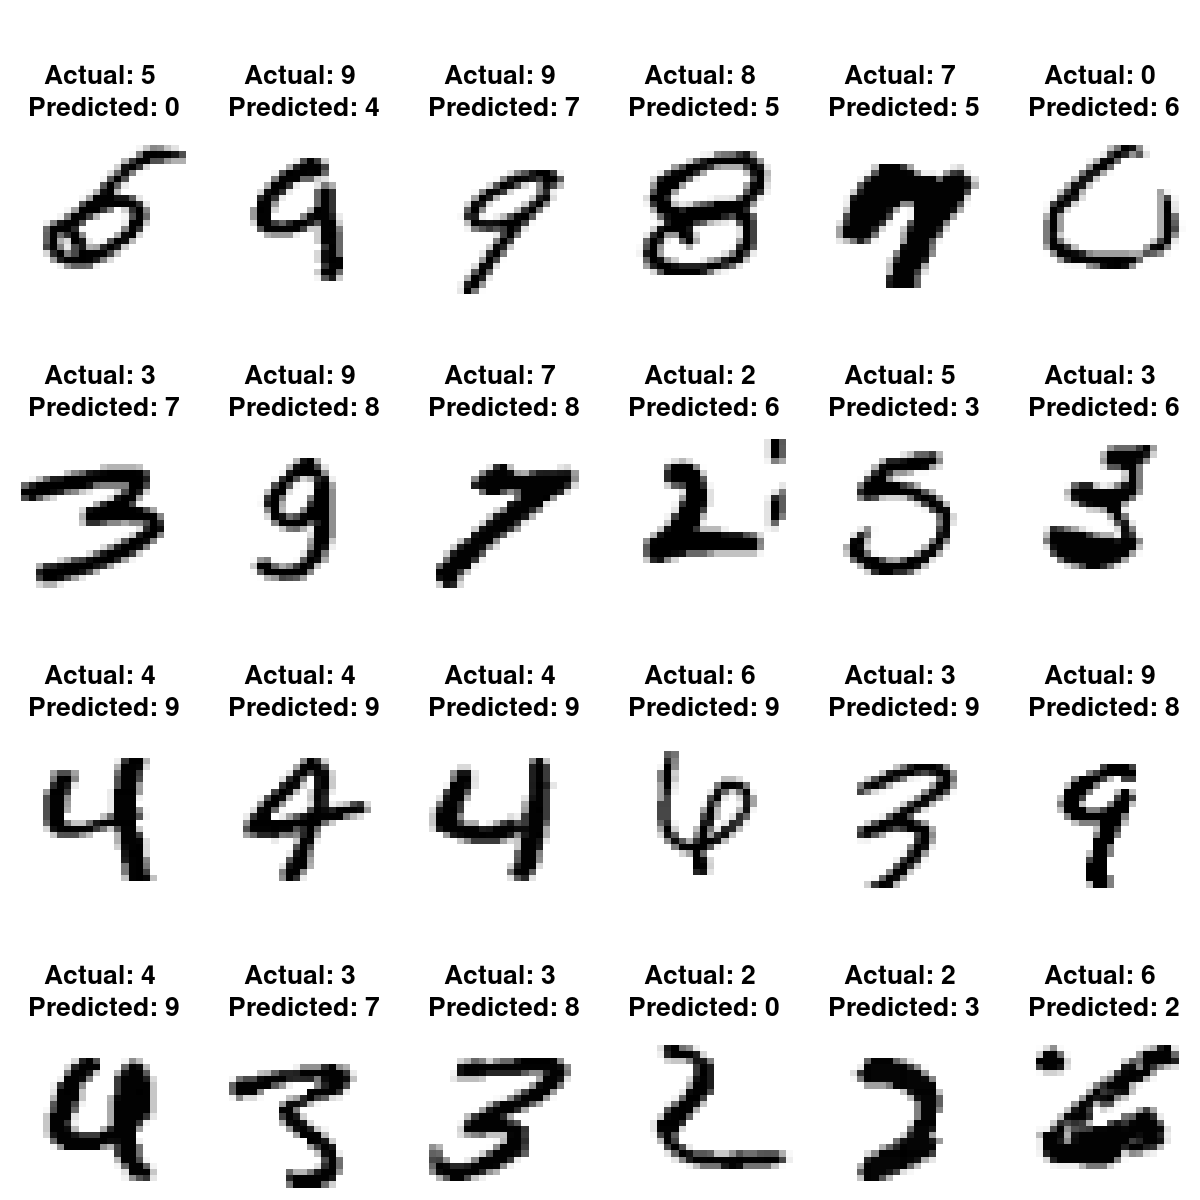

In [15]:
incorrect = which(predictions != Y_test)
display_incorrect(incorrect, predictions, X_test, Y_test)

Some of these mistakes are pretty easy to understand, some of these digits are a bit whacky! But for others, it's pretty clear what the digits are, and its a bit puzzling as to why the network couldn't get them.

There's obviously lots of room for improvement here; we've barely scratched the surface! Using more complicated neural networks, its possible to get an accuracy very close to 100%. 

## That's it! 🥳
Congratulations, if you've made it this far you understand the basics of how to implement a simple neural network from scratch! Before you go, here's a few final things to consider:
- Today we created a neural network from scratch. In practice, no-one really does this (why re-invent the wheel?) Instead, we use specialised machine learning packages and libraries to help make this process easier.
- While the handwritten digit problem is a nice introduction to neural networks, its definitely on the simple side. It's simple enough that we can actually get decent results with linear models, and other ML models like SVMs and random forests.
- If you're keen to dive deeper into this example, try some of the extra challenges below.
- If you want to learn more about coding in R, machine learning or neural networks, check out the resources suggested in Part 5, linked below.


## Extra challenges 🔥 

If you're keen to dive a little bit deeper into this example, here are some more challenging tasks to try.

### Mild 🌶️ 🙂

Suitable for beginners, no experience expected.

- **Setting the learning rate:** We didn't talk much about the learning rate. Try training the network with a few different values. What happens?

- **Increasing the accuracy of the model:** 
The current ~80% accuracy is not bad, but leaves room for improvement. Play around with the parameters of the model and the training processs to see if you can get a better accuracy.

- **Leaving in the labels:** When we created our testing data, we stripped out the labels. What would happen if we kept the labels, and removed some other row instead? Try it!

### Spicy 🌶️🌶️ 😳

Coding experience and/or some math experience will be helpful, you might need to write a little bit of code yourself. 

- **Understanding the math of forward prop:** Take a look back at the forward propagation function, and try to develop an understanding of exactly what's going on.

- **Passing in random noise:** Create a matrix full of random values and feed it through a trained network. What happens? Does this make sense?

- **Visualising weights:** Visualise the weights that connect all neurons in the input layer to the first neuron in the hidden layer.

### Flaming 🌶️🌶️🌶️ 🥵

Coding & statistical experience, patience and high level of enthusiasm required, these aren't easy! 

- **Understanding the math of backward prop:** Take a look back at the backward propagation function, and try to develop an understanding of exactly what's going on.

- **Trying other statistical models:** Although we've looked at using neural networks to classify digits, this problem is relatively simple, and other statistical methods can get high accuracies too. Try another model (e.g an SVM or a random forest) and see how the performance compares. 

- **More hidden layers:** Extend the model so that an arbitrary number of hidden layers can be used.

- **Using a NN package:** Above, we coded up our neural network from scratch to improve our understanding. In practice, people pre-written code to create models. Have a look at the [neuralnet](https://cran.r-project.org/web/packages/neuralnet/index.html) package, and try to train it using the MNIST data.

---
## ↪️ Next up: [Part 5 🚀 - Discovering more](./5_Discovering_More.ipynb)
